# Hello Bunch!

In [1]:
%matplotlib inline

import pandas as pd
import spacy
import numpy as np
import nltk
import seaborn

## Load data and prepare it

In [2]:
df = pd.read_pickle('data/labelled_dataset.pickle')

In [3]:
df.shape

(91580, 2)

In [4]:
df.labelmax.unique()

array(['customer', 'collaboration', 'adaptability', 'detail', 'result',
       'integrity', 'null'], dtype=object)

In [5]:
df = df[(df.labelmax != 'null')].reset_index()

In [6]:
df.head()

,index,text,labelmax
0,0,Pros - The people who work here are brilliant ...,customer
1,1,Pros Start-up vibes Fast growing company Tech-...,customer
2,2,"Pros The team is great, I love the ambition of...",collaboration
3,3,"Pros The company is constantly growing, and at...",adaptability
4,4,Pros Cool office. Friendly people. Good atmosp...,collaboration


It looks like the text is made up of three parts: __Pros__ and __Cons__ and __Advice to Management__.

In [7]:
df[df.text.str.contains('Pros')].shape

(91045, 3)

In [8]:
df[df.text.str.contains('Cons')].shape

(91045, 3)

In [9]:
df[df.text.str.contains('Advice to Management')].shape

(56058, 3)

### balanced? No!

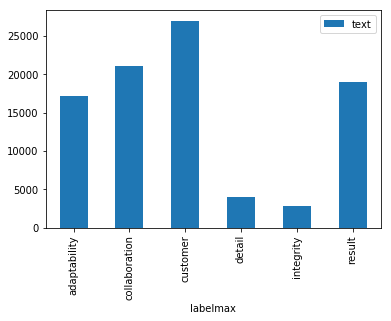

In [10]:
df.groupby('labelmax').count().plot(kind='bar')

As seen in the previous cells, the data set isn't quite balanced. Some algorithms cannot cope with unbalanced datasets and train models which take the number of class occurences into account. A binary dataset with a proportion of 80-20 could therefore influence such an algorithm in a way that it always says class X and gains 80 percent accuracy. We could use over- and undersampling which only trains on balanced data.

### prepare data

My basic data preparation encompasses word tokenizing and lemmatizing of the texts and the generation of a single word and a bigram bag-of-words. This approach gets the single words from a text and lemmatizes it, e.g. _cats_ gets transformed to _cat_. A bag-of-words is a matrix in which each row is a data sample and each column a specific word. The values are the number of occurences of the respective word in the respective data sample. A bigram bag-of-words is similar but looks at 2 succeeding words at the same time, i.e. _the cat drinks_ gets transformed in the bigram bag-of-words (_the cat_, _cat drinks_).

In [11]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import cross_validate

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
wordnet_lemmatizer = WordNetLemmatizer()

In [14]:
def tokenize(review):
    return [wordnet_lemmatizer.lemmatize(w) for w in nltk.word_tokenize(review)]

In [15]:
vectorizer = CountVectorizer(tokenizer=tokenize, ngram_range=(1,1), min_df=5)

In [16]:
y = df.labelmax

In [17]:
vectorizer2 = CountVectorizer(tokenizer=tokenize, ngram_range=(2,2), min_df=5)

In [18]:
X_2 = vectorizer2.fit_transform(df.text)

### sample 10%

I only sample 10% of the data due to resource sparcity. The sampling will help me quickly compare models and approaches. The best approach will be used to train on the whole data.

In [19]:
sample_ids = df.sample(frac=0.1).index

In [20]:
X_sample = X[sample_ids, :]

In [21]:
y_sample = y.iloc[sample_ids]

In [22]:
X_sample_2 = X_2[sample_ids, :]

## Compare different algorithms

### Logistic Regression on Bag-of-Words

When I work on classification tasks, I always try Logistic Regression (LR) first. Moreover, for language models, the bag-of-words approach is the first one to try. Here, the single words occuring in a text are getting weighted by LR and future predictions will take those weights to calculate the respective classes. The combination of words or the syntax of single sentences is not considered with that approach. The advantage, however, is its simplicity. After the training is done, we can easily look at the coefficients and tell what words influence the model to which extent. I will compare _Logistic Regression_ with _Random Forest_, _SVC_, _LinearSVC_ and _Multinomial Naive Bayes_. Other algorithms as _XGBoost_ etc could be tested, too. When comparing different approaches, I use cross validation with a folding number of 3. Here, the training set is randomly divided in training and test set. The classifier is trained with the training set and validated with the test set. This happens 3 times. The cross validation approach helps assure that train and test split wasn't a lucky pick which shows good examples but performs bad otherwise.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [24]:
results = []
for alg in [LogisticRegression, RandomForestClassifier, SVC, LinearSVC, MultinomialNB]:
    model = alg()
    cv_results = cross_validate(model, X_sample, y_sample, return_train_score=False)
    results.append(cv_results['test_score'])

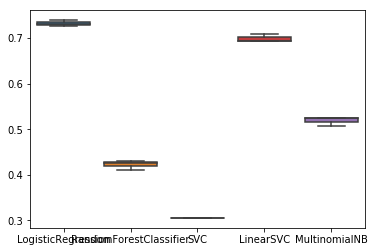

In [25]:
seaborn.boxplot(x=['LogisticRegression', 
                   'RandomForestClassifier', 
                   'SVC',
                   'LinearSVC',
                   'MultinomialNB'
                  ],
                y=results)

In [26]:
results

[array([0.72547684, 0.73901193, 0.73133311]),
 array([0.42608992, 0.43032368, 0.41084214]),
 array([0.30551771, 0.30562181, 0.30548926]),
 array([0.69414169, 0.70971039, 0.69382884]),
 array([0.50715259, 0.5253833 , 0.52403682])]

Surprisingly, in comparison with other classifiers, Logistic Regression does very well for that task taking into account that it has only 10% of the data. In other tasks I've done so far, I could gain more percentages with Random Forest than Logisitic Regression. Moreover, Logistic Regression isn't influenced by unbalanced data. Therefore, we do not need to over- or undersample while training.

### bigram bag-of-words

In [27]:
lr_n2 = LogisticRegression()
cv_results = cross_validate(lr_n2, X_sample_2, y_sample, return_train_score=False)
cv_results['test_score']

array([0.54461853, 0.5407155 , 0.54960791])

The bigram approach does not work better than the single word bag-of-words! Hence, the combination of words doesn't contribute as much as the single words. Therefore, I will try to continue working on the single word features. At next, I won't just use word lemmatizing but rather use stemming and ignore stopwords.

### stemming

In [28]:
stemmer = PorterStemmer()

In [29]:
def tokenize_st(review):
    return [stemmer.stem(w) for w in tokenize(review)]

In [30]:
vectorizer = CountVectorizer(tokenizer=tokenize_st, ngram_range=(1,1), min_df=5)

In [31]:
X_st = vectorizer.fit_transform(df.text)

In [32]:
X_sample_st = X_st[sample_ids, :]

In [33]:
lr_st = LogisticRegression()
cv_results = cross_validate(lr_st, X_sample_st, y_sample, return_train_score=False)
cv_results['test_score']

array([0.76396458, 0.77614991, 0.76508694])

Stemming improves the model even more. This is because of the generalization of different words with the same stem. As I already mentioned, a model just looking at single words works probably better for that data than a more complex one. Stemming helps combining different words with the same stem, reduces the feature size and simplifies the model, i.e. the words _inspection_ and _inspecting_ both get transformed into the stem _inspect_. We continue using stemmed features.

### ignore stop words

Stop words are words like _a, and_ or _or_. Usually, these words do not add meaning to bag-of-words models and therefore can be ignored.

In [34]:
from nltk.corpus import stopwords

In [35]:
stop_words = set(stopwords.words('english'))

In [36]:
def tokenize_stop(review):
    return [stemmer.stem(w) for w in nltk.word_tokenize(review) if w not in stop_words]

In [37]:
vectorizer = CountVectorizer(tokenizer=tokenize_stop, ngram_range=(1,1), min_df=5)

In [38]:
X_stop = vectorizer.fit_transform(df.text)

In [39]:
X_sample_stop = X_stop[sample_ids, :]

In [40]:
lr_stop = LogisticRegression()
cv_results = cross_validate(lr_stop, X_sample_stop, y_sample, return_train_score=False)
cv_results['test_score']

array([0.77384196, 0.78228279, 0.77224685])

As seen, ignoring the stop words improves the model slightly.

### multi_class='multinomial'

The _multinomial_ parameter builds a multi-class model using multinomial regression which build a classifier that learns dependent variables, i.e. updating the parameters for one class also influences the parameters being important for another one. In contrast, the _ovr_ (the other option here) meaning one-vs-rest builds independent classifiers for each class modeling the probability that class _k_ is more likely than all the other classes.

In [41]:
lr_stop = LogisticRegression(solver='newton-cg', multi_class='multinomial')
cv_results = cross_validate(lr_stop, X_sample_stop, y_sample, return_train_score=False)
cv_results['test_score']

array([0.79058281, 0.8       , 0.78825858])

Using the multinomial solver _newton-cg_ with _multinomial_ regression helped improving the results even a bit more.

## Test final approach on whole dataset

In [42]:
X = vectorizer.fit_transform(df.text)
y = df.labelmax

In [43]:
lr_final = LogisticRegression(solver='newton-cg', multi_class='multinomial')
cv_results = cross_validate(lr_final, X, y, cv=5, return_train_score=False)
cv_results['test_score']

array([0.93597276, 0.92707304, 0.9232797 , 0.93068981, 0.92239249])

In [44]:
print('Final accuracy with 5-fold cross validation:', cv_results['test_score'].mean())

Final accuracy with 5-fold cross validation: 0.9278815580890247


![title](https://i.giphy.com/media/nXxOjZrbnbRxS/giphy.webp)

# Next steps for further improvements

My model is a rather simple one. If I could have more time, I would go on trying to juggle around with the text data. Here, some steps would be trying to remove parameters that do not contribute to the predictions. This could be done with __Principle Component Analysis__ which is trying to find correlations between parameters and reduces them to a given number by combining correlating parameters. Moreover, I would start doing __hyperparameter optimization__ to play around with the Logistic Regression parameters as penalties, regularization terms, scaling or which solver to use. For this approach the library _hyperopt-sklearn_ comes quite handy as it can be easily used together with _sklearn_. Additionally, I could have tried using both bigram and single word bag-of-words (maybe with PCA afterwards) to find significant combinations and single words together.

Another possibility for finding a good model can be __fastText__ which is a more complex algorithm creating word vectors or using already trained ones. It creates a classifier model that can be trained in a very fast and well-performing way. It creates word representations with the Word2Vec approach and feds those representations into a linear classifier.

For other languages, I am suggesting translating the texts to english to use this model. As we only look at single words and their contribution to different classes, those words in other languages could indicate similar company culture. The problem is often that labeled data for other languages than english is sparse. Therefore, I suggest using fastText as you can use already trained word vectors for 157 different languages (https://fasttext.cc/docs/en/crawl-vectors.html) which can then be fine-tuned with less data.

At last, I am a fan of this particular web page: https://github.com/sebastianruder/NLP-progress. Here, state-of-the-art methods on different NLP tasks are tracked. The best model for text classification is ULMFiT which is a transfer learning model, i.e. a neural network model that was already trained on a dataset like Wikipedia and whose knowledge is further used (fine-tuned) on other tasks like the specific one here. The disadvantage of those complex models is the fact that they are more complicated to analyze (sometimes it isn't possible at all). Logistic Regression, anyhow, is easy to analyze but performs maybe a bit worse. In general, using too complex models is a decision that carefully has to be thought about as both debugging and explaining suffer from those models. A business that has to explain its decisions, like a bank that must explain why someone didn't get a loan, would rather use a slighty worse but more simple model.

# Deploying the model

To use the model in production, I like the approach of using __Flask__. First, I would create a __pipeline__ involving the tokenizer, count vectorizer and the logistic regression model and pickle it to a file which will be loaded in a Flask app. Here, it needs to be loaded into memory to avoid loading it from disk with every API call. A solution is sklearn's __joblib__ module to load it into a global variable. This Flask app has an endpoint that takes in the raw text / features of the model. It predicts the output which then get returned. Here, I would prefer a JSON endpoint. I have also already used django's rest-framework for deploying models but I like the simplicity and flexibility of Flask a bit more.

# Predict classes for unlabeled texts

### train on whole dataset

In [45]:
from sklearn.pipeline import Pipeline

In [46]:
clf = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=tokenize_stop, ngram_range=(1,1), min_df=5)),
    ('logreg', LogisticRegression(solver='newton-cg', multi_class='multinomial'))
])

In [47]:
clf = clf.fit(df.text, df.labelmax)

### check training accuracy

In [48]:
test = df.sample(frac=0.05)
clf.score(test.text, test.labelmax)

0.9914323374340949

### load unlabeled texts

In [49]:
import os

In [50]:
os.mkdir('data/unlabelled-dataset-predictions/')

In [51]:
for uld_path in os.listdir('data/unlabelled-dataset/'):
    current_path = os.path.join('data/unlabelled-dataset/', uld_path)
    new_path = os.path.join('data/unlabelled-dataset-predictions/', uld_path)
    print(current_path)
    p_df = pd.read_json(current_path)
    if p_df.empty:
        continue
    p_df['prediction'] = clf.predict(p_df.text)
    p_df.to_json(new_path, orient='records')

data/unlabelled-dataset/Acuris.json
data/unlabelled-dataset/parlamind.json
data/unlabelled-dataset/Blacklane.json
data/unlabelled-dataset/Medigo.json
data/unlabelled-dataset/Helix Sleep.json
data/unlabelled-dataset/Mediaocean.json
data/unlabelled-dataset/Kontist.json
data/unlabelled-dataset/Truphone.json
data/unlabelled-dataset/Stadium Goods.json
data/unlabelled-dataset/KBS.json
data/unlabelled-dataset/Comtravo.json
data/unlabelled-dataset/Viacom.json
data/unlabelled-dataset/Morgan Hunt.json
data/unlabelled-dataset/Vaniday Global Services.json
data/unlabelled-dataset/WorldFirst.json
data/unlabelled-dataset/Finiata.json
data/unlabelled-dataset/Investigo.json
data/unlabelled-dataset/Lemonade.json
data/unlabelled-dataset/YAS.json
data/unlabelled-dataset/Framestore.json
data/unlabelled-dataset/Homebell.json
data/unlabelled-dataset/EE.json
data/unlabelled-dataset/Healthfirst (New York).json
data/unlabelled-dataset/Bedly.json
data/unlabelled-dataset/Liverpool Echo.json
data/unlabelled-datase

data/unlabelled-dataset/Joblift.json
data/unlabelled-dataset/Marie Claire Magazine.json
data/unlabelled-dataset/Wimdu.json
data/unlabelled-dataset/KidPass.json
data/unlabelled-dataset/Nomura Securities.json
data/unlabelled-dataset/Brolly.json
data/unlabelled-dataset/payleven.json
data/unlabelled-dataset/Initiative.json
data/unlabelled-dataset/Clark.json
data/unlabelled-dataset/Mishipay.json
data/unlabelled-dataset/Caroobi.json
data/unlabelled-dataset/Coureon Logistics.json
